## Dynamics on Dipolar Pake Pattern

## Goals
Simulate how dynamics change static pake pattern using spheric harmonics function for emsemble calculation 
## system setup
we use diffusion on the cone as the model system
the bond vector is retreated as H-N bond

## How-to
1. simulte diffusion on a cone to get the bond vector (check)
2. calculate according chemical shift values for each orientation of the bone vector
3. generate Ix or Ix + iIj trajactory: Ix = cos(theta), theta = dt*frequency (rad/s)    frequency = ppm* B0 * 2pi
4. FT to the frequency conponent 
5. figure out how to emsemble average: can we still use Wigner-D matrix 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R
import sympy as sp
from sympy.physics.quantum.spin import Rotation as WignerRotation
import numpy as np
import math
from math import factorial as fact

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors



# alternative step 1
def simulate_vector_on_cone2(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000, axis=np.array([0, 0, 1])):
    """
    Simulate a unit vector hopping on a cone surface with fixed S2 and correlation time tau_c.
    
    Returns:
        vectors: (num_steps, 3) array of unit vectors
    """
    # Cone angle from S²
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)

    # Ornstein-Uhlenbeck parameters for azimuthal diffusion
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)  # Unit noise strength
    phi = 0.0
    axis = axis / np.linalg.norm(axis)

    # Rotation matrix to align cone with axis
    R_align = rotation_matrix_from_vectors(np.array([0, 0, 1]), axis)

    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        # Update azimuthal angle using Ornstein-Uhlenbeck process
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi

        # Point on cone with fixed θ and current φ
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vec_local = np.array([x, y, z])

        # Rotate to align cone with specified axis
        vec_global = R_align @ vec_local
        vectors[i] = vec_global

    return vectors

def rotation_matrix_from_vectors(a, b):
    """Find the rotation matrix that aligns vector a to vector b"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if c == 1:
        return np.eye(3)
    if c == -1:
        # 180° rotation around arbitrary perpendicular axis
        perp = np.array([1, 0, 0]) if not np.allclose(a, [1, 0, 0]) else np.array([0, 1, 0])
        return rotation_matrix_from_vectors(a, np.cross(a, perp))
    s = np.linalg.norm(v)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))

In [2]:
# test of step 1
HN_vector = simulate_vector_on_cone2(S2=0.85, tau_c=0.0001, dt=1e-6, num_steps=3000,axis=np.array([1,0,0]))
print("HN_vector shape:", HN_vector.shape)

HN_vector shape: (3000, 3)


In [43]:
# module for step 2
# write Spatial part of the spherical harmonics for dipolar interaction with axis along z, only rank=2, other is  zero
import sympy as sp
from sympy.physics.quantum.spin import Rotation

# note: when we need study both CSA and Dipolar, T_2m need to be calculated in the principal axis system of the CSA tensor

T_2m = {
    -2: 0,
    -1: 0,
    0: sp.sqrt(3/2) * (-2),
    1: 0,
    2: 0
}
# define the Wigner D-matrix elements for rank l=2 
# using the sympy Rotation module
# def D_matrix(l, m, m_prime, alpha, beta, gamma):
#     R = Rotation.D(l, m, m_prime, alpha, beta, gamma)
#     return sp.simplify(R.doit())


# now calculate the components after rotation with euler angles alpha, beta, gamma
def rotate_sph_harmonics(T, alpha, beta, gamma):
    T_rot = {}
    for m in T:
        T_rot[m] = sum(
            sp.simplify(T[m_prime] * Rotation.D(2, m, m_prime, alpha, beta, gamma))
            for m_prime in T
        )
    return T_rot

alpha, beta, gamma = sp.symbols('alpha beta gamma', real=True)

T_rot = rotate_sph_harmonics(T_2m, alpha, beta, gamma)

# print T_rot
for m in T_rot:
    print(f"T_rot[{m}] = {T_rot[m]}")

T_rot[-2] = -0.612372435695794*sqrt(6)*exp(2*I*alpha)*sin(beta)**2
T_rot[-1] = -0.612372435695794*sqrt(6)*exp(I*alpha)*sin(2*beta)
T_rot[0] = -1.83711730708738*cos(2*beta) - 0.612372435695794
T_rot[1] = 0.612372435695794*sqrt(6)*exp(-I*alpha)*sin(2*beta)
T_rot[2] = -0.612372435695794*sqrt(6)*exp(-2*I*alpha)*sin(beta)**2


In [42]:
#---step 2. Convert H-N orientaion to chemical shift frequency----

r = 1.0e-10  # distance between the two spins in meters 1 å
gamma1 = 2.675e8  # gyromagnetic ratio for proton in /s/T
# gyromagnetic ratio for nitrogen in rad/s/T
gamma2 = 2.713e7  # gyromagnetic ratio for nitrogen-15 in /s/T
gamma3= 6.728e7 # gyro for carbon-13 /s/T

def dipolar_prefactor_Hz(r, gamma1, gamma2):
    mu_0 = 4 * sp.pi * 1e-7  # T·m/A
    hbar = 1.0545718e-34     # J·s
    h = 6.62607015e-34       # Planck's constant in J·s

    # Energy in joules
    H_dip_J = - (mu_0 / (4 * sp.pi)) * (gamma1 * gamma2 * hbar**2) / r**3

    # Convert to Hz: E / h
    H_dip_Hz = H_dip_J / h

    return H_dip_Hz

import numpy as np
from scipy.spatial.transform import Rotation as R

def euler_from_z_to_vec(v, seq='zyz', degrees=False):
    """
    Calculate Euler angles to rotate (0,0,1) onto one or more unit vectors.

    Parameters
    ----------
    v : array-like, shape (3,) or (N,3)
        Target unit vector(s).
    seq : str
        Euler angle sequence, e.g. 'xyz', 'zyx', 'zxz', etc.
    degrees : bool
        Return angles in degrees if True, radians otherwise.

    Returns
    -------
    euler_angles : ndarray, shape (3,) or (N,3)
        Euler angles that rotate (0,0,1) onto v.
    """
    v = np.atleast_2d(np.array(v, dtype=float))
    v /= np.linalg.norm(v, axis=1, keepdims=True)

    z_axis = np.array([0.0, 0.0, 1.0])
    cos_theta = np.clip(v @ z_axis, -1.0, 1.0)  # shape (N,)
    theta = np.arccos(cos_theta)

    # cross product to get rotation axis
    axis = np.cross(np.broadcast_to(z_axis, v.shape), v)
    axis_norm = np.linalg.norm(axis, axis=1, keepdims=True)
    axis = np.divide(axis, axis_norm, where=axis_norm>1e-15)  # avoid div by zero

    # default rotation vectors (general case)
    rotvec = axis * theta[:, None]

    # parallel case: theta ~ 0 → no rotation
    parallel_mask = np.isclose(theta, 0.0)
    rotvec[parallel_mask] = 0.0

    # anti-parallel case: theta ~ pi → rotate pi about any perpendicular axis
    antiparallel_mask = np.isclose(theta, np.pi)
    if np.any(antiparallel_mask):
        # pick axis perpendicular to z, use x unless z=[±1,0,0]
        fallback_axis = np.array([1.0,0.0,0.0])
        bad = np.isclose(np.abs(z_axis @ fallback_axis), 1.0)
        if bad:
            fallback_axis = np.array([0.0,1.0,0.0])
        rotvec[antiparallel_mask] = fallback_axis * np.pi

    # build rotation and convert to Euler
    rot = R.from_rotvec(rotvec)
    euler_angles = rot.as_euler(seq, degrees=degrees)

    # return shape (3,) if input was a single vector
    if euler_angles.shape[0] == 1:
        return euler_angles[0]
    return euler_angles


import numpy as np
import sympy as sp

# places to improve: convert symbolic expressions to numerical functions to improve performance

# def xyz2freq(vectors, B0):
#     """
#     Convert xyz unit vectors to dipolar coupling frequencies for given orientations.

#     Parameters
#     ----------
#     vectors : ndarray, shape (N, 3)
#         Unit vectors representing orientations.
#     B0 : float
#         Magnetic field strength in Tesla.

#     Returns
#     -------
#     frequencies : ndarray, shape (N,)
#         Dipolar coupling frequencies (Hz) for each input orientation.
#     """
#     # --- Euler angles from z-axis to each vector ---
#     euler_angles = euler_from_z_to_vec(vectors)    # shape (N,3)
#     alpha_vals, beta_vals, gamma_vals = euler_angles.T

#     # --- Symbolic definition ---
#     alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma')

#     # Dipolar prefactor (define r, gamma1, gamma2 externally)
#     D = dipolar_prefactor_Hz(r, gamma1, gamma2)   # <-- Make sure B0 is used if needed!

#     # calculate each term of T_rot with according alpha_sym_beta_sym, gamma_sym
#     T_rot = np.zeros((3, 3), dtype=object)
#     for i in range(3):
#         for j in range(3):
#             T_rot[i, j] = sp.symbols(f'T_rot_{i}_{j}')  
    
#     # 

#     # Example expression for orientation dependence (adjust to your case)
#     expr = D * T_rot[0] * sp.sqrt(2/sp.Integer(3))/2  # replace T_rot[0] with your actual tensor expression

#     # --- Build vectorized numerical function ---
#     expr_func = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')

#     # --- Direct vectorized evaluation (no loop) ---
#     frequencies = expr_func(alpha_vals, beta_vals, gamma_vals)
#     return np.asarray(frequencies, dtype=float)


# instead of calculate only T2,0, we can calculate all T2,m
def xyz2T2m(vectors, B0):
    """
    Calculate all T2,m for given orientations.

    Parameters
    ----------
    vectors : ndarray, shape (N, 3)
        Unit vectors representing orientations.
    B0 : float
        Magnetic field strength in Tesla.

    Returns
    -------
    T2m : ndarray, shape (N, M)
        All T2,m values for each input orientation.
    """
 # --- Euler angles from z-axis to each vector ---
    euler_angles = euler_from_z_to_vec(vectors)    # shape (N,3)
    alpha_vals, beta_vals, gamma_vals = euler_angles.T

    # --- Symbolic definition ---
    alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma')

    # Dipolar prefactor (define r, gamma1, gamma2 externally)
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)   # <-- Make sure B0 is used if needed!


    T2m = {}
    for m in range(-2, 3):
        expr = D * sp.sqrt(2/sp.Integer(3)) * T_rot[m]
        expr_func = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')
        T2m[m] = expr_func(alpha_vals, beta_vals, gamma_vals)  # modify per m if needed
    return T2m




In [53]:
# test xyz2T2m
T2m_values = xyz2T2m(HN_vector, B0=1.0)
print("T2,m values shape:", T2m_values[-1].shape)

T2,m values shape: (1000,)


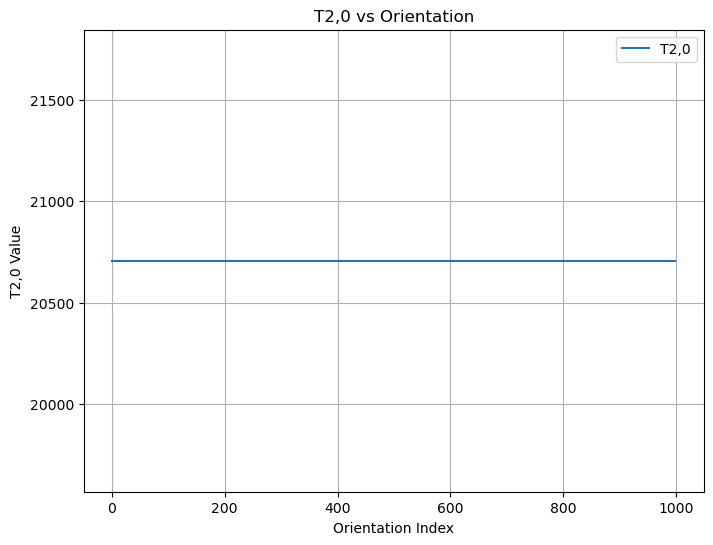

In [48]:
# plot T2,0 term
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(T2m_values[0], label='T2,0')
plt.xlabel('Orientation Index')
plt.ylabel('T2,0 Value')
plt.title('T2,0 vs Orientation')
plt.legend()
plt.grid()
plt.show()

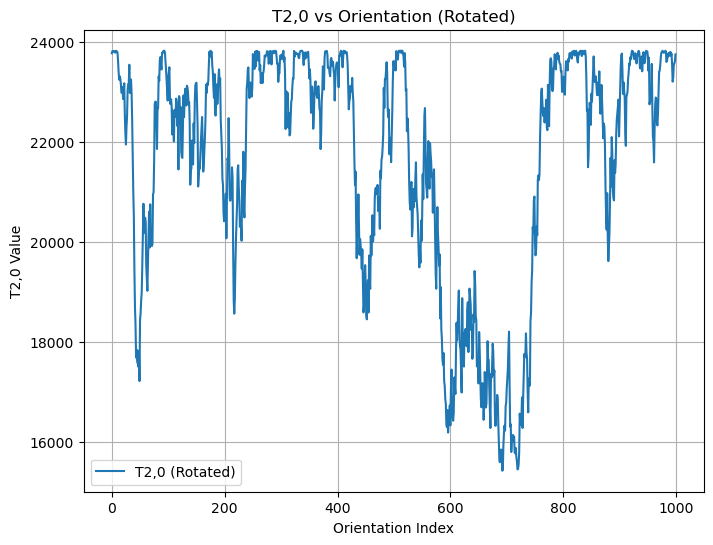

In [47]:
# now using wigner matrix to calcualte t2,0 term after rotation

# example of rotation angle 
alpha = 0.1  # radians
beta = 0.2   # radians
gamma = 0.3  # radians  

wig_d = {}
for m in range(-2, 3):
    expr = Rotation.D(2, m, 0, alpha, beta, gamma)
    wig_d[m] = complex(expr.evalf().doit())  # Convert to complex number

T_20_rotated = sum(T2m_values[m] * wig_d[m] for m in range(-2, 3))
# # Flatten to 1D, evaluate each element, then reshape back
# T_20_numeric = np.vectorize(lambda x: complex(x.evalf().doit()))(T_20_rotated)
#T_20_real = np.real(T_20_r)


# # #plot T_20_rotated
plt.figure(figsize=(8, 6))
plt.plot(np.real(T_20_rotated), label='T2,0 (Rotated)')
plt.xlabel('Orientation Index')
plt.ylabel('T2,0 Value')
plt.title('T2,0 vs Orientation (Rotated)')
plt.legend()
plt.grid()
plt.show()
# #print("T_20_rotated shape:", T_20_rotated.shape)

In [58]:
## Step 3: Calculate Ix trajatory

# this is for single orientation

def calculate_Ix_trajectory(frequencies, dt):
    """
    Calculate the Ix trajectory based on the dipolar coupling frequencies and time points.

    Parameters
    ----------
    frequencies : array-like, shape (n,)
        Dipolar coupling frequencies.
    dt: float
        Time step for the simulation.
    time_points: int
        Number of time points to simulate.

    Returns
    -------
    Ix_trajectory : ndarray, shape (m,)
        Calculated Ix trajectory.
    """
    # first convert frequency to processing angles
    angles = 2 * np.pi * frequencies * dt


    # calculate cumulative sum of angles
    cum_angles = np.cumsum(angles)

    # calculate Ix at each time point as cos(cum_angles)
    Ix_trajectory = np.cos(cum_angles)
    Iy_trajectory = np.sin(cum_angles)

    return Ix_trajectory, Iy_trajectory


# this is for ensemble calcualtion

def calculate_Ip_trajectory(frequencies, dt):
    """
    Calculate ensemble-averaged Ix and Iy trajectories using cumulative angles.
    
    Parameters
    ----------
    frequencies : ndarray, shape (N, M, 1)
        Dipolar coupling frequencies for each ensemble member and time step.
    dt : float
        Time step for the simulation.
    
    Returns
    -------
    Ix_avg : ndarray, shape (M,)
        Ensemble-averaged Ix trajectory.
    Iy_avg : ndarray, shape (M,)
        Ensemble-averaged Iy trajectory.
    """
    frequencies = np.array(frequencies, dtype=float)  # shape (N, M, 1)
    
    # Phase increment per step
    delta_angles = 2 * np.pi * frequencies * dt  # shape (N, M, 1)
    
    # Cumulative angles along time axis (axis=1)
    cum_angles = np.cumsum(delta_angles, axis=1)  # shape (N, M, 1)
    
    # Compute Ix, Iy
    Ix = np.cos(cum_angles)  # shape (N, M, 1)
    Iy = np.sin(cum_angles)
    
    # Ensemble average over first axis (N)
    Ix_avg = Ix.mean(axis=0).squeeze()  # shape (M,)
    Iy_avg = Iy.mean(axis=0).squeeze()  # shape (M,)
    
    return Ix_avg, Iy_avg



In [78]:
# test step 3
dt = 1e-6
time_points = 500
Ix_test, Iy_test = calculate_Ix_trajectory(frequencies, dt)

In [ ]:
# q: can I get rotated frequency directly from frequencies_z through some transformation?
# in order to do that we need calculate all T2,m terms instead of only T2,0
# then we transform through wigner_D and retain the T2,0 after tranformation. D0,m * T2,m 






In [55]:
# simulate ensemble 

from scipy.spatial.transform import Rotation as R
import numpy as np
from sympy.physics.wigner import wigner_d
from sympy import N
from sympy.physics.quantum.spin import Rotation

N_rot = 10000
rot = R.random(num=N_rot)
euler = rot.as_euler('zyz', degrees=False)  # radians
alpha, beta, gamma = euler[:,0], euler[:,1], euler[:,2]

m_vals = np.arange(-2, 3)
wig_d = np.empty((len(m_vals), N_rot), dtype=complex)

wig_d = np.array([
    [complex(Rotation.D(2, m, 0, a, b, g).evalf().doit()) for a,b,g in zip(alpha, beta, gamma)]
    for m in range(-2, 3)
])

# convert T2m_values into numpy array
T2m_values_np = np.array([T2m_values[m] for m in range(-2, 3)])  # shape (5,1000)


# T2m_values = np.array([...])  # shape (5, ?) 
T_20_rotated = np.tensordot(T2m_values_np, wig_d, axes=(0,0))

print("T_20_rotated shape:", T_20_rotated.shape)

# sum over all orientations
T_20_rotated_sum = np.average(T_20_rotated, axis=1)
print("T_20_rotated_sum shape:", T_20_rotated_sum.shape)


T_20_rotated shape: (1000, 10000)
T_20_rotated_sum shape: (1000,)


/Users/yunyao_1/miniforge3/envs/nmr_py310/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


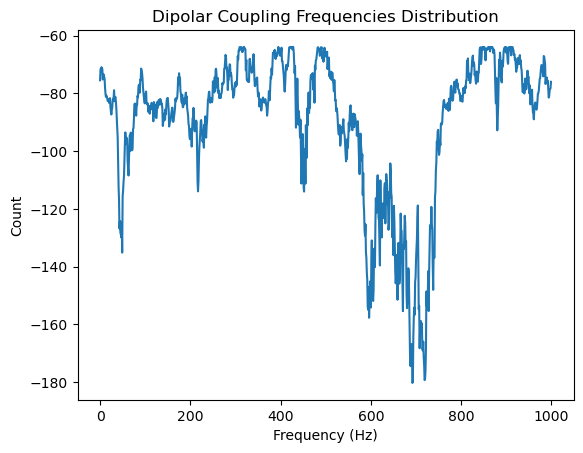

In [56]:
# test the new xyz2freq_numpy function

# plot frequencies_test
import matplotlib.pyplot as plt

plt.plot(T_20_rotated_sum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('Dipolar Coupling Frequencies Distribution')
plt.show()  




In [64]:
print("T_20_rotated shape:", T_20_rotated.shape)  # should be (N_rot, ?)

T_20_rotated shape: (1000, 10000)


In [69]:
# calculate Ix
dt = 1e-6  # time step in seconds
Ix_ensemble, Iy_ensemble = calculate_Ip_trajectory(T_20_rotated.T*0.5, dt)
# calculate average_Ix
print(Ix_ensemble.shape)

/var/folders/21/7pys71p923x0l1lrp08ll2w00000gp/T/ipykernel_43267/1590565428.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies = np.array(frequencies, dtype=float)  # shape (N, M, 1)


(1000,)


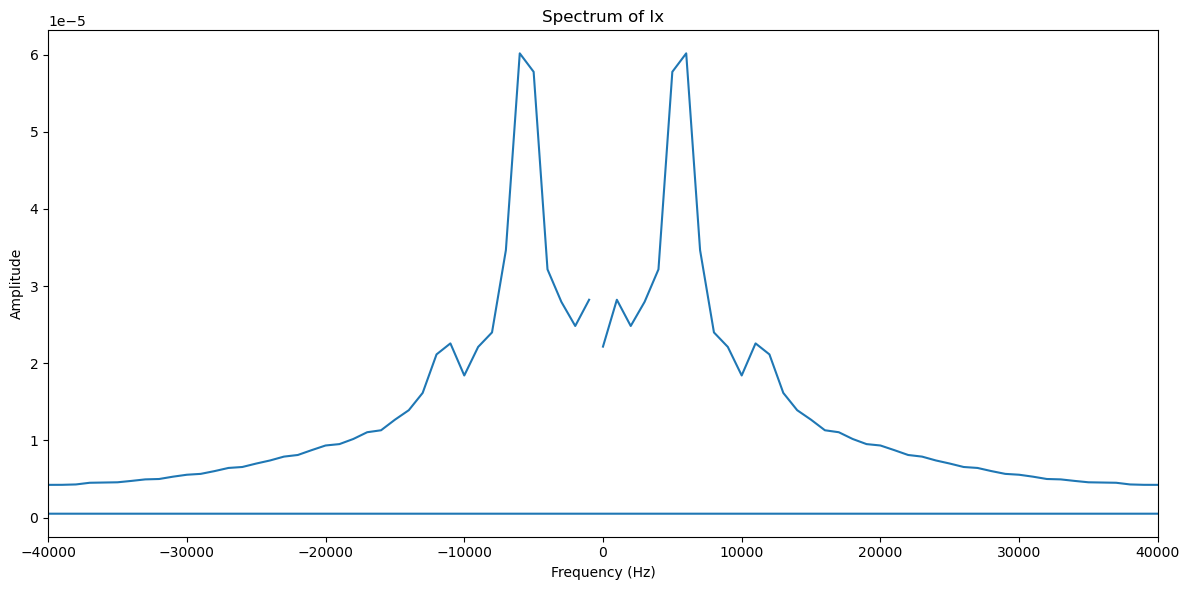

In [70]:
# calculate spectrum
def calculate_spectrum(Ix, Iy, dt):
    fft_vals= np.fft.fft(Ix)
    freq = np.fft.fftfreq(len(Ix), d=dt)
    #normalize
    fft_vals = fft_vals * dt
    return freq, fft_vals

freq, fft_vals = calculate_spectrum(Ix_ensemble, Iy_ensemble, dt)
# plot the spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(freq, np.abs(fft_vals))
plt.title('Spectrum of Ix')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(-40000, 40000)

plt.tight_layout()
plt.show()

In [ ]:
%writefile dynamics_HN_Sph.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R
import sympy as sp
from sympy.physics.quantum.spin import Rotation as WignerRotation
import numpy as np
import math
from math import factorial as fact
import sympy as sp
from sympy.physics.quantum.spin import Rotation

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors



# note: when we need study both CSA and Dipolar, T_2m need to be calculated in the principal axis system of the CSA tensor

T_2m = {
    -2: 0,
    -1: 0,
    0: sp.sqrt(3/2) * (-2),
    1: 0,
    2: 0
}

def rotate_sph_harmonics(T, alpha, beta, gamma):
    T_rot = {}
    for m in T:
        T_rot[m] = sum(
            sp.simplify(T[m_prime] * Rotation.D(2, m, m_prime, alpha, beta, gamma))
            for m_prime in T
        )
    return T_rot

alpha, beta, gamma = sp.symbols('alpha beta gamma', real=True)

T_rot = rotate_sph_harmonics(T_2m, alpha, beta, gamma)


r = 1.0e-10  # distance between the two spins in meters 1 å
gamma1 = 2.675e8  # gyromagnetic ratio for proton in /s/T
# gyromagnetic ratio for nitrogen in rad/s/T
gamma2 = 2.713e7  # gyromagnetic ratio for nitrogen-15 in /s/T
gamma3= 6.728e7 # gyro for carbon-13 /s/T

def dipolar_prefactor_Hz(r, gamma1, gamma2):
    mu_0 = 4 * sp.pi * 1e-7  # T·m/A
    hbar = 1.0545718e-34     # J·s
    h = 6.62607015e-34       # Planck's constant in J·s

    # Energy in joules
    H_dip_J = - (mu_0 / (4 * sp.pi)) * (gamma1 * gamma2 * hbar**2) / r**3

    # Convert to Hz: E / h
    H_dip_Hz = H_dip_J / h

    return H_dip_Hz

import numpy as np
from scipy.spatial.transform import Rotation as R

def euler_from_z_to_vec(v, seq='zyz', degrees=False):
    """
    Calculate Euler angles to rotate (0,0,1) onto one or more unit vectors.

    Parameters
    ----------
    v : array-like, shape (3,) or (N,3)
        Target unit vector(s).
    seq : str
        Euler angle sequence, e.g. 'xyz', 'zyx', 'zxz', etc.
    degrees : bool
        Return angles in degrees if True, radians otherwise.

    Returns
    -------
    euler_angles : ndarray, shape (3,) or (N,3)
        Euler angles that rotate (0,0,1) onto v.
    """
    v = np.atleast_2d(np.array(v, dtype=float))
    v /= np.linalg.norm(v, axis=1, keepdims=True)

    z_axis = np.array([0.0, 0.0, 1.0])
    cos_theta = np.clip(v @ z_axis, -1.0, 1.0)  # shape (N,)
    theta = np.arccos(cos_theta)

    # cross product to get rotation axis
    axis = np.cross(np.broadcast_to(z_axis, v.shape), v)
    axis_norm = np.linalg.norm(axis, axis=1, keepdims=True)
    axis = np.divide(axis, axis_norm, where=axis_norm>1e-15)  # avoid div by zero

    # default rotation vectors (general case)
    rotvec = axis * theta[:, None]

    # parallel case: theta ~ 0 → no rotation
    parallel_mask = np.isclose(theta, 0.0)
    rotvec[parallel_mask] = 0.0

    # anti-parallel case: theta ~ pi → rotate pi about any perpendicular axis
    antiparallel_mask = np.isclose(theta, np.pi)
    if np.any(antiparallel_mask):
        # pick axis perpendicular to z, use x unless z=[±1,0,0]
        fallback_axis = np.array([1.0,0.0,0.0])
        bad = np.isclose(np.abs(z_axis @ fallback_axis), 1.0)
        if bad:
            fallback_axis = np.array([0.0,1.0,0.0])
        rotvec[antiparallel_mask] = fallback_axis * np.pi

    # build rotation and convert to Euler
    rot = R.from_rotvec(rotvec)
    euler_angles = rot.as_euler(seq, degrees=degrees)

    # return shape (3,) if input was a single vector
    if euler_angles.shape[0] == 1:
        return euler_angles[0]
    return euler_angles


# instead of calculate only T2,0, we can calculate all T2,m
def xyz2T2m(vectors, B0):
    """
    Calculate all T2,m for given orientations.

    Parameters
    ----------
    vectors : ndarray, shape (N, 3)
        Unit vectors representing orientations.
    B0 : float
        Magnetic field strength in Tesla.

    Returns
    -------
    T2m : ndarray, shape (N, M)
        All T2,m values for each input orientation.
    """
 # --- Euler angles from z-axis to each vector ---
    euler_angles = euler_from_z_to_vec(vectors)    # shape (N,3)
    alpha_vals, beta_vals, gamma_vals = euler_angles.T

    # --- Symbolic definition ---
    alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma')

    # Dipolar prefactor (define r, gamma1, gamma2 externally)
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)   # <-- Make sure B0 is used if needed!


    T2m = {}
    for m in range(-2, 3):
        expr = D * sp.sqrt(2/sp.Integer(3)) * T_rot[m]
        expr_func = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')
        T2m[m] = expr_func(alpha_vals, beta_vals, gamma_vals)  # modify per m if needed
    return T2m


def calculate_Ip_trajectory(frequencies, dt):
    """
    Calculate ensemble-averaged Ix and Iy trajectories using cumulative angles.
    
    Parameters
    ----------
    frequencies : ndarray, shape (N, M, 1)
        Dipolar coupling frequencies for each ensemble member and time step.
    dt : float
        Time step for the simulation.
    
    Returns
    -------
    Ix_avg : ndarray, shape (M,)
        Ensemble-averaged Ix trajectory.
    Iy_avg : ndarray, shape (M,)
        Ensemble-averaged Iy trajectory.
    """
    frequencies = np.array(frequencies, dtype=float)  # shape (N, M, 1)
    
    # Phase increment per step
    delta_angles = 2 * np.pi * frequencies * dt  # shape (N, M, 1)
    
    # Cumulative angles along time axis (axis=1)
    cum_angles = np.cumsum(delta_angles, axis=1)  # shape (N, M, 1)
    
    # Compute Ix, Iy
    Ix = np.cos(cum_angles)  # shape (N, M, 1)
    Iy = np.sin(cum_angles)
    
    # Ensemble average over first axis (N)
    Ix_avg = Ix.mean(axis=0).squeeze()  # shape (M,)
    Iy_avg = Iy.mean(axis=0).squeeze()  # shape (M,)
    
    return Ix_avg, Iy_avg

# we then read in the wigner_matrix for N from a libaray
def read_wigner_matrix(N):
    """
    Read the Wigner D-matrix for a given N from a library.

    Parameters
    ----------
    N : int
        The quantum number for which to read the Wigner D-matrix.

    Returns
    -------
    wigner_matrix : ndarray, shape (3, 3)
        The Wigner D-matrix for the given N.
    """
    # Placeholder for actual library call
    if N == 5000:
        wig_d, alpha, beta, gamma = np.load('wigner_d_spin2_N5000.npz', allow_pickle=True)  # Replace with actual Wigner D-matrix
    elif N == 20000:
        wig_d, alpha, beta, gamma = np.load('wigner_d_spin2_N20000.npz', allow_pickle=True)  # Replace with actual Wigner D-matrix
    elif N == 100000:
        wig_d, alpha, beta, gamma = np.load('wigner_d_spin2_N100000.npz', allow_pickle=True)  # Replace with actual Wigner D-matrix
    else:
        raise ValueError("Unsupported N value. Supported values are 5000, 20000, and 100000.")
    return wig_d

def calculate_spectrum(Ix, dt, window='hann', alpha=3.0, sigma=0.4, position=0.5):
    """
    Calculate spectrum using FFT with different window functions.

    Parameters
    ----------
    Ix : ndarray, shape (M,)
        Time-domain trajectory.
    dt : float
        Time step for the simulation.
    window : str, optional
        Window function type: 'hann', 'hamming', 'blackman', 'exponential', 
        'gaussian', 'sinebell', or 'none'.
    alpha : float, optional
        Decay rate for exponential window (used if window='exponential').
    sigma : float, optional
        Standard deviation factor for gaussian window (used if window='gaussian').
    position : float, optional
        Relative peak location of gaussian window in [0, 1].
        0 = start, 0.5 = center, 1 = end.

    Returns
    -------
    freq : ndarray
        Frequency axis.
    fft_vals : ndarray
        FFT of windowed Ix trajectory.
    """
    N = len(Ix)
    n = np.arange(N)

    # --- Select window ---
    if window.lower() == 'hann':
        w = np.hanning(N)
    elif window.lower() == 'hamming':
        w = np.hamming(N)
    elif window.lower() == 'blackman':
        w = np.blackman(N)
    elif window.lower() == 'exponential':
        w = np.exp(-alpha * n / N)
    elif window.lower() == 'gaussian':
        # peak index determined by position parameter
        peak_idx = position * (N - 1)
        w = np.exp(-0.5 * ((n - peak_idx) / (sigma * (N-1)/2))**2)
    elif window.lower() == 'sinebell':
        w = np.sin(np.pi * n / (N-1))
    elif window.lower() == 'none':
        w = np.ones(N)
    else:
        raise ValueError(f"Unknown window type '{window}'")

    # --- Apply window to signal ---
    Ix_win = Ix * w

    # --- FFT ---
    fft_vals = np.fft.fft(Ix_win) * dt
    freq = np.fft.fftfreq(N, d=dt)

    return freq, fft_vals

# --- main script ---
def main():
    parser = argparse.ArgumentParser(description="Simulate dipolar NMR trajectories and spectra.")
    parser.add_argument("--S2", type=float, default=0.85,
                        help="Order parameter (default 0.85)")
    parser.add_argument("--tau_c", type=float, default=0.01,
                        help="Correlation time (default 0.01)")
    parser.add_argument("--dt", type=float, default=1e-4,
                        help="Time step (default 1e-4)")
    parser.add_argument("--num_steps", type=int, default=10000,
                        help="Number of time steps (default 10000)")
    parser.add_argument("--B0", type=float, default=14.1,
                        help="Magnetic field in Tesla (default 14.1)")
    parser.add_argument("--r", type=float, required=True,
                        help="Internuclear distance in meters")
    parser.add_argument("--gamma1", type=float, required=True,
                        help="Gyromagnetic ratio of spin1 (rad/T/s)")
    parser.add_argument("--gamma2", type=float, required=True,
                        help="Gyromagnetic ratio of spin2 (rad/T/s)")
    parser.add_argument("--plot", action="store_true",
                        help="If set, plot the spectrum.")
    parser.add_argument("--N", type=int, default=5000,
                        help="Number of ensemble members (three options, 5000, 20000, 100000)")
    parser.add_argument("--output_prefix", type=str, default=None,
                        help="Prefix for saving results (optional)")

    # --- New parameters for spectrum windowing ---
    parser.add_argument("--window", type=str, default="hann",
                        choices=["none", "hann", "hamming", "blackman", 
                                 "exponential", "gaussian", "sinebell"],
                        help="Window function for FFT (default: hann)")
    parser.add_argument("--alpha", type=float, default=3.0,
                        help="Decay rate for exponential window (default: 3.0)")
    parser.add_argument("--sigma", type=float, default=0.4,
                        help="Width factor for Gaussian window (default: 0.4)")
    parser.add_argument("--position", type=float, default=0.5,
                        help="Relative peak location for Gaussian window [0..1] (default: 0.5)")

    args = parser.parse_args()

    # 1. simulate trajectory (single vector path)
    HN_vector = simulate_vector_on_cone(args.S2, args.tau_c, args.dt, args.num_steps)

    # 2. create ensemble by random rotation
    wigner_d = read_wigner_matrix(args.N)  # should be in shape (5, N)

    # 3. convert to frequencies  # (5, M) 
    freq_single_traj = xyz2T2m(HN_vector, args.B0, args.r, args.gamma1, args.gamma2)

    # 3.5 apply Wigner rotation
    freq_ensemble = np.einsum('ij,ik->jk', wigner_d, freq_single_traj)

    # 4. calculate Ix/Iy
    Ix_avg, Iy_avg = calculate_Ip_trajectory(freq_ensemble, args.dt)

    # 5. calculate spectrum
    freq, fft_vals = calculate_spectrum(Ix_avg, args.dt)

    # 6. save outputs if requested
    if args.output_prefix:
        np.save(f"{args.output_prefix}_Ix.npy", Ix_avg)
        np.save(f"{args.output_prefix}_Iy.npy", Iy_avg)
        np.save(f"{args.output_prefix}_freq.npy", freq)
        np.save(f"{args.output_prefix}_fft.npy", fft_vals)
        print(f"Saved results to {args.output_prefix}_*.npy")

    # 7. optional plot
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,4))
        plt.plot(freq, np.abs(fft_vals))
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Intensity")
        plt.title("Dipolar Spectrum")
        plt.grid(True)
        plt.show()

    return freq, fft_vals

if __name__ == "__main__":
    main()







In [72]:
%%writefile dynamics_HN_Sph.py
import os
import numpy as np
import argparse
from scipy.spatial.transform import Rotation as R


# === Precompute dipolar prefactor ===
hbar = 1.054571817e-34  # J*s (Planck constant over 2π)


# === Precompute dipolar prefactor using numpy ===
D_prefactor = -(1e-7/ (4.0 * np.pi)) * (1.0 / r**3) * (gamma1 * gamma2) * hbar

# === Symbolic setup for T2m lambdas ===
alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma', real=True)

# Define spherical tensor rank-2 rotation terms T_rot[m]  !!
T_rot = {
    -2: sp.exp(-2*sp.I*alpha_sym)*sp.sin(beta_sym)**2,
    -1: sp.exp(-1*sp.I*alpha_sym)*sp.sin(2*beta_sym),
     0: (3*sp.cos(beta_sym)**2 - 1),
     1: sp.exp(1*sp.I*alpha_sym)*sp.sin(2*beta_sym),
     2: sp.exp(2*sp.I*alpha_sym)*sp.sin(beta_sym)**2
}
# Define spherical tensor rank-2 rotation terms T_rot[m]  !!

# Pre-lambdify T2m expressions
T2m_expr = {}
for m in range(-2, 3):
    expr = D_prefactor * sp.sqrt(2/sp.Integer(3)) * T_rot[m]
    T2m_expr[m] = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')

def euler_from_z_to_vec(vectors):
    z_axis = np.array([0, 0, 1])
    N = vectors.shape[0]
    euler_angles = np.zeros((N, 3))
    for i, vec in enumerate(vectors):
        v = vec / np.linalg.norm(vec)
        if np.allclose(v, z_axis):
            euler_angles[i] = [0, 0, 0]
        else:
            rot_axis = np.cross(z_axis, v)
            rot_angle = np.arccos(np.clip(np.dot(z_axis, v), -1.0, 1.0))
            r = R.from_rotvec(rot_axis / np.linalg.norm(rot_axis) * rot_angle)
            euler_angles[i] = r.as_euler('zyz', degrees=False)
    return euler_angles

def xyz2T2m(vectors):
    euler_angles = euler_from_z_to_vec(vectors)
    alpha_vals, beta_vals, gamma_vals = euler_angles.T
    return np.array([T2m_expr[m](alpha_vals, beta_vals, gamma_vals) for m in T2m_expr])


def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)

    phi = np.zeros(num_steps)
    noise = sigma * np.sqrt(dt) * np.random.randn(num_steps)
    for i in range(1, num_steps):
        phi[i] = phi[i-1] - gamma * phi[i-1] * dt + noise[i]

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.full(num_steps, np.cos(theta))
    return np.column_stack((x, y, z))

def read_wigner_matrix(N, path="."):
    filename = os.path.join(path, f"wigner_d_spin2_N{N}.npz")
    data = np.load(filename)
    return data['wig_d']

# --- Step 3: Calculate Ix/Iy trajectory ---
def calculate_Ip_trajectory(frequencies, dt):
    frequencies = np.array(frequencies, dtype=float)
    delta_angles = 2 * np.pi * frequencies * dt
    cum_angles = np.cumsum(delta_angles, axis=1)
    Ix = np.cos(cum_angles)
    Iy = np.sin(cum_angles)
    Ix_avg = Ix.mean(axis=0).squeeze()
    Iy_avg = Iy.mean(axis=0).squeeze()
    return Ix_avg, Iy_avg

# --- Step 4: Calculate spectrum ---

def calculate_spectrum(Ix, dt, window='exponential', alpha=3.0, sigma=0.4, position=0.5):
    """
    Calculate spectrum using FFT with different window functions.

    Parameters
    ----------
    Ix : ndarray, shape (M,)
        Time-domain trajectory.
    dt : float
        Time step for the simulation.
    window : str, optional
        Window function type: 'hann', 'hamming', 'blackman', 'exponential', 
        'gaussian', 'sinebell', or 'none'.
    alpha : float, optional
        Decay rate for exponential window (used if window='exponential').
    sigma : float, optional
        Standard deviation factor for gaussian window (used if window='gaussian').
    position : float, optional
        Relative peak location of gaussian window in [0, 1].
        0 = start, 0.5 = center, 1 = end.

    Returns
    -------
    freq : ndarray
        Frequency axis.
    fft_vals : ndarray
        FFT of windowed Ix trajectory.
    """
    N = len(Ix)
    n = np.arange(N)

    # --- Select window ---
    if window.lower() == 'hann':
        w = np.hanning(N)
    elif window.lower() == 'hamming':
        w = np.hamming(N)
    elif window.lower() == 'blackman':
        w = np.blackman(N)
    elif window.lower() == 'exponential':
        w = np.exp(-alpha * n / N)
    elif window.lower() == 'gaussian':
        # peak index determined by position parameter
        peak_idx = position * (N - 1)
        w = np.exp(-0.5 * ((n - peak_idx) / (sigma * (N-1)/2))**2)
    elif window.lower() == 'sinebell':
        w = np.sin(np.pi * n / (N-1))
    elif window.lower() == 'none':
        w = np.ones(N)
    else:
        raise ValueError(f"Unknown window type '{window}'")

    # --- Apply window to signal ---
    Ix_win = Ix * w

    # --- FFT ---
    fft_vals = np.fft.fft(Ix_win) * dt
    freq = np.fft.fftfreq(N, d=dt)

    return freq, fft_vals

# --- main script ---
def main():
    parser = argparse.ArgumentParser(description="Simulate cone dynamics effect on dipolar spectra.")
    parser.add_argument("--S2", type=float, default=0.85,
                        help="Order parameter (default 0.85)")
    parser.add_argument("--tau_c", type=float, default=0.01,
                        help="Correlation time (default 0.01)")
    parser.add_argument("--dt", type=float, default=1e-4,
                        help="Time step (default 1e-4)")
    parser.add_argument("--num_steps", type=int, default=10000,
                        help="Number of time steps (default 10000)")
    parser.add_argument("--B0", type=float, default=14.1,
                        help="Magnetic field in Tesla (default 14.1)")
    parser.add_argument("--r", type=float, required=True,
                        help="Internuclear distance in meters")
    parser.add_argument("--gamma1", type=float, required=True,
                        help="Gyromagnetic ratio of spin1 (rad/T/s)")
    parser.add_argument("--gamma2", type=float, required=True,
                        help="Gyromagnetic ratio of spin2 (rad/T/s)")
    parser.add_argument("--plot", action="store_true",
                        help="If set, plot the spectrum.")
    parser.add_argument("--wigner_file_path", type=str, default="wigner_d_order2_N5000.npz",
                        help="Path to the Wigner matrix file (default: wigner.npy)")
    parser.add_argument("--N", type=int, default=5000,
                        help="Number of ensemble members (default 5000)")
    parser.add_argument("--output_prefix", type=str, default=None,
                        help="Prefix for saving results (optional)")

    # --- New parameters for spectrum windowing ---
    parser.add_argument("--window", type=str, default="hann",
                        choices=["none", "hann", "hamming", "blackman", 
                                 "exponential", "gaussian", "sinebell"],
                        help="Window function for FFT (default: hann)")
    parser.add_argument("--alpha", type=float, default=3.0,
                        help="Decay rate for exponential window (default: 3.0)")
    parser.add_argument("--sigma", type=float, default=0.4,
                        help="Width factor for Gaussian window (default: 0.4)")
    parser.add_argument("--position", type=float, default=0.5,
                        help="Relative peak location for Gaussian window [0..1] (default: 0.5)")

    args = parser.parse_args()

    # 1. simulate trajectory (single vector path)
    HN_vector = simulate_vector_on_cone(args.S2, args.tau_c, args.dt, args.num_steps)

    # 2. convert to frequencies
    freq_single= xyz2T2m(HN_vector)

    # 3. extend to ensemble 
    freq_ensemble = np.einsum('ij,ik->jk', read_wigner_matrix(args.N), freq_single)

    # 4. calculate Ix/Iy
    Ix_avg, Iy_avg = calculate_Ip_trajectory(freq_ensemble, args.dt)

    # 5. calculate spectrum
    freq, fft_vals = calculate_spectrum(Ix_avg, args.dt)

    # 6. save outputs if requested
    if args.output_prefix:
        np.save(f"{args.output_prefix}_Ix.npy", Ix_avg)
        np.save(f"{args.output_prefix}_Iy.npy", Iy_avg)
        np.save(f"{args.output_prefix}_freq.npy", freq)
        np.save(f"{args.output_prefix}_fft.npy", fft_vals)
        print(f"Saved results to {args.output_prefix}_*.npy")

    # 7. optional plot
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,4))
        plt.plot(freq, np.abs(fft_vals))
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Intensity")
        plt.title("Dipolar Spectrum")
        plt.grid(True)
        plt.show()

    return freq, fft_vals

if __name__ == "__main__":
    main()




Writing dynamics_HN_Sph.py
